### This is the tutorial of deep learning on FashionMNIST dataset using Pytorch. We will build a Convolutional Neural Network for predicting the classes of Dataset. I am assuming you know the basics of deep leanrning like layer architecture... convolution concepts. Without further ado... Lets start the tutorial.

# **Importing Important Libraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
root = "./MNIST"
download = True
train_set = FashionMNIST(root, train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionMNIST(root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

In [18]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





In [19]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [20]:
len(test_set)

10000

In [21]:
len(train_set)

60000

9


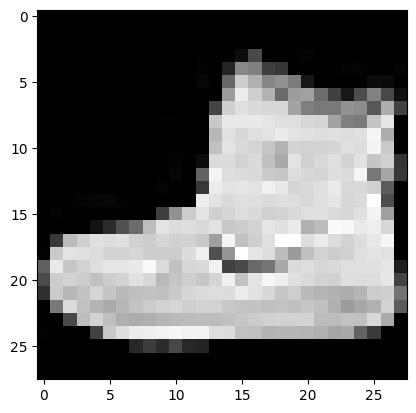

In [22]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [23]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

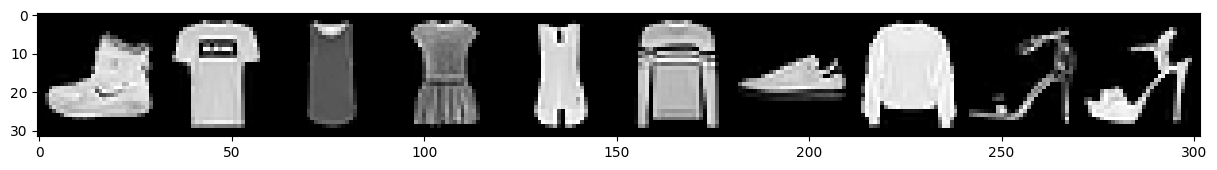

In [24]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


## Building a CNN 


*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [25]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [26]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [27]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


/Users/shubov/PycharmProjects/safe_ai_seminar_ws22-23/venv/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.45864295959472656, Accuracy: 88.04000091552734%
Iteration: 1000, Loss: 0.3041573166847229, Accuracy: 88.66000366210938%
Iteration: 1500, Loss: 0.35453861951828003, Accuracy: 88.70999908447266%
Iteration: 2000, Loss: 0.21017040312290192, Accuracy: 89.23999786376953%
Iteration: 2500, Loss: 0.14069776237010956, Accuracy: 89.4800033569336%
Iteration: 3000, Loss: 0.19218002259731293, Accuracy: 90.18000030517578%


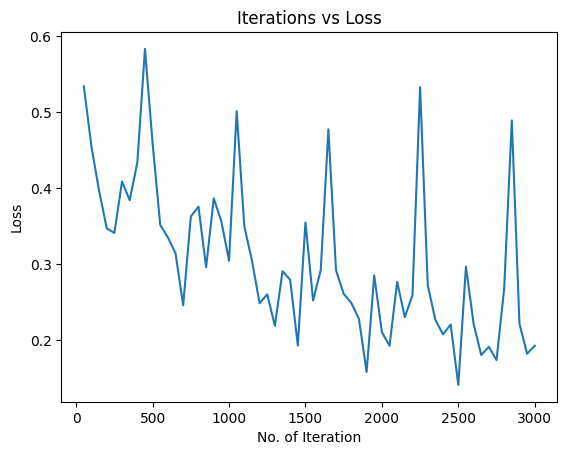

In [28]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

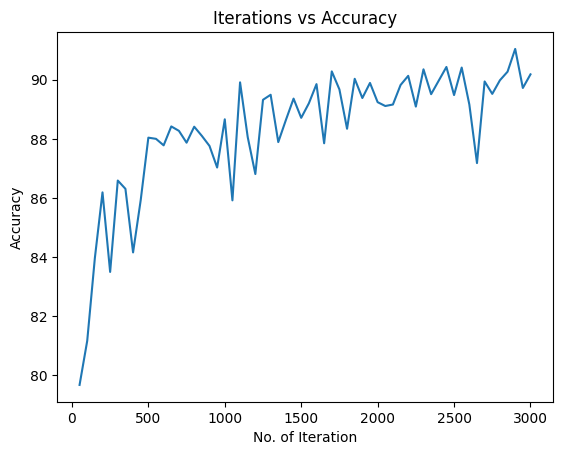

In [29]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [30]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.90%
Accuracy of Trouser: 97.90%
Accuracy of Pullover: 84.20%
Accuracy of Dress: 88.40%
Accuracy of Coat: 88.30%
Accuracy of Sandal: 96.90%
Accuracy of Shirt: 64.60%
Accuracy of Sneaker: 96.00%
Accuracy of Bag: 98.80%
Accuracy of Ankle Boot: 97.40%


In [31]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [32]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     60000
           1       0.97      0.98      0.97     60000
           2       0.83      0.83      0.83     60000
           3       0.87      0.89      0.88     60000
           4       0.80      0.83      0.81     60000
           5       0.96      0.96      0.96     60000
           6       0.71      0.65      0.68     60000
           7       0.93      0.94      0.94     60000
           8       0.96      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000




In [33]:
torch.save(model, "./models/fashion_cnn.pk")

In [34]:
from temperature_scaling import ModelWithTemperature
model_t = ModelWithTemperature(model)

In [35]:
model_t.set_temperature(test_loader)

AssertionError: Torch not compiled with CUDA enabled